# Study of loan processing data using machine learning

## Init project, init docker

In [1]:
# import libraries
import pandas as pd
import numpy as np
import clickhouse_connect

import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

>Initial Docker Setup <br>
Create user with sha256 pass and rm default user (./users/default-user.xml)
> past file `konsin1988-user.xml` in users dir

>Enable SQL user mode:

> `<access_management>1</access_management>`

> `<named_collection_control>1</named_collection_control>`

> `<show_named_collections>1</show_named_collections>`

> `<show_named_collections_secrets>1</show_named_collections_secrets>`

 

In [4]:
# Get clickhouse client from docker
client = clickhouse_connect.get_client(host = 'localhost', port = '8123', user = 'konsin1988', password = 'konsin1988konsin1988')

In [5]:
# Create role admin IF NOT EXISTS
query = r'''
    CREATE ROLE IF NOT EXISTS admin
'''
client.command(query)

In [5]:
# Grant to admin full access 
query = r'''
    GRANT ALL ON *.* TO admin WITH GRANT OPTION
'''
client.command(query)

> .. and add role to xml user's file
```<role>admin</role>```

In [5]:
# Checking the roles
pd.DataFrame(client.query('SHOW ACCESS').named_results()).query('ACCESS.str.contains("GRANT ALL")')

,ACCESS
9,GRANT ALL ON *.* TO konsin1988 WITH GRANT OPTION
10,GRANT ALL ON *.* TO admin WITH GRANT OPTION


## Data

In [113]:
# Create database german_cr and switch to german_cr
client.command(r'CREATE DATABASE IF NOT EXISTS german_cr')
client.command(r'USE german_cr')

In [11]:
# Checking the database was created
query = r'''
    SELECT name FROM system.databases
'''
pd.DataFrame(client.query(query).named_results())

,name
0,INFORMATION_SCHEMA
1,default
2,german_cr
3,information_schema
4,system


In [144]:
# Create table german_credit with appropriate data types

# query = r'''
#     DROP TABLE IF EXISTS german_cr.german_credit;
# '''
# client.command(query)
query = r'''
    CREATE TABLE IF NOT EXISTS german_cr.german_credit(
        `age` Nullable(Int64),
        `sex` Nullable(String),
        `job` Nullable(Int64),
        `housing` Nullable(String),
        `saving_accounts` Nullable(String),
        `checking_account` Nullable(String),
        `credit_amount` Nullable(Int64),
        `duration` Nullable(Int64),
        `purpose` Nullable(String),
        `default` Nullable(Int64),
        `contract_dt` DateTime('UTC'),
        `client_id` Nullable(Int64)
    ) ENGINE MergeTree ORDER BY contract_dt;
'''
client.command(query)

``` Insert data from csv to table via bash ```
> in terminal <br>
curl -i -X POST -T "./german_credit.csv"  'http://localhost:8123/?query=INSERT%20INTO%20german_credit%20FORMAT%20CSV'

In [2]:
%%bash
curl -i -X POST -T  "./german_credit.csv" -u konsin1988:konsin1988konsin1988 \
'http://localhost:8123/?query=INSERT%20INTO%20german_cr.german_credit%20FORMAT%20CSVWithNames'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 69563    0     0  100 69563      0  2178k --:--:-- --:--:-- --:--:-- 2191k


HTTP/1.1 200 OK
Date: Sun, 23 Feb 2025 15:12:14 GMT
Connection: Keep-Alive
Content-Type: text/plain; charset=UTF-8
Access-Control-Expose-Headers: X-ClickHouse-Query-Id,X-ClickHouse-Summary,X-ClickHouse-Server-Display-Name,X-ClickHouse-Format,X-ClickHouse-Timezone
X-ClickHouse-Server-Display-Name: 88beeec225b4
Transfer-Encoding: chunked
X-ClickHouse-Query-Id: 085e5173-6b6a-498a-a834-584cfcc656bd
X-ClickHouse-Timezone: UTC
Keep-Alive: timeout=10, max=9999
X-ClickHouse-Summary: {"read_rows":"1000","read_bytes":"133778","written_rows":"1000","written_bytes":"133778","result_rows":"1000","result_bytes":"133778","elapsed_ns":"28957511"}



In [111]:
# Test data (head) and dtypes of table
query = r'''
    SELECT * 
    FROM german_cr.german_credit
    LIMIT 5
'''
pd.DataFrame(client.query(query).named_results())

,age,sex,job,housing,saving_accounts,checking_account,credit_amount,duration,purpose,default,contract_dt,client_id
0,20,male,2,own,None,little,2996,24,furniture/equipment,1,2007-05-01 07:17:29,495
1,49,female,2,own,little,moderate,1092,12,radio/TV,0,2007-05-01 08:41:46,288
2,30,female,3,own,little,moderate,4795,36,radio/TV,0,2007-05-01 12:42:45,141
3,39,female,1,own,None,moderate,932,6,education,0,2007-05-01 20:28:44,215
4,31,male,2,own,little,None,2775,18,car,1,2007-05-01 23:14:02,598


In [10]:
query = r'''
    SELECT * 
    FROM german_cr.german_credit
'''
pd.DataFrame(client.query(query).named_results()).info()

DatabaseError: HTTPDriver for http://localhost:8123 received ClickHouse error code 81
 Code: 81. DB::Exception: Database german_cr does not exist. (UNKNOWN_DATABASE) (version 24.3.6.48 (official build))


In [64]:
# list of columns
# query = r'''
#     SELECT column_name
#     FROM information_schema.COLUMNS
#     WHERE table_schema = 'german_cr' AND table_name = 'german_credit'
# '''
# columns_gc = pd.DataFrame(client.query(query).named_results())['column_name'].to_list()

## Сount the number of loans issued and refusals

In [188]:
query = r'''
    SELECT * 
    FROM (
    SELECT 
        1 AS index,
        'Number' AS `Type of value`,
        CAST(SUM(IF(default = 1, 1, 0)), 'Int64') AS `Issued loans`,
        CAST(SUM(IF(default = 0, 1, 0)), 'Int64') AS `Refusal to issue a loan`
    FROM german_cr.german_credit
    
    UNION ALL
    
    SELECT 
        2,
        'Total amount',
        SUM(IF(default = 1, credit_amount, 0)) AS `Issued loans`,
        SUM(IF(default = 0, credit_amount, 0)) AS `Refusal to issue a loan`
    FROM german_cr.german_credit
    
    UNION ALL
    
    SELECT 
        3,
        'Percent, %',
        CAST(SUM(IF(default = 1, credit_amount, 0)) * 100 / SUM(credit_amount), 'Int64'),
        CAST(SUM(IF(default = 0, credit_amount, 0)) * 100 / SUM(credit_amount), 'Int64')
    FROM german_cr.german_credit
    )
    ORDER BY index
'''
pd.DataFrame(client.query(query).named_results()).drop(columns = ['index'])

,Type of value,Issued loans,Refusal to issue a loan
0,Number,300,700
1,Total amount,1181438,2089820
2,"Percent, %",36,63


## Amount of loans issued for the quarter

In [320]:
# get all starts of quarters between first and last dates from german_credit
query = r'''
    DROP VIEW IF EXISTS quarters
'''
client.command(query)

query = r'''
    CREATE VIEW IF NOT EXISTS quarters AS 
    WITH get_first AS (
    SELECT MIN(toUnixTimestamp(contract_dt)) AS first_stamp
    FROM german_cr.german_credit
    ), get_last AS (
    SELECT MAX(toUnixTimestamp(contract_dt)) AS last_stamp
    FROM german_cr.german_credit
    ), get_quarters AS (
    SELECT DISTINCT toStartOfQuarter(toDateTime(arrayJoin(range(first_stamp, last_stamp, 60 * 60 * 24 * 90)))) AS quarters
    FROM get_first, get_last
    )
    SELECT 
        quarters AS quarter_start_date,
        toQuarter(quarters) AS quarter_number
    FROM get_quarters
'''
client.command(query)

query = r'''
    SELECT * FROM quarters
'''
pd.DataFrame(client.query(query).named_results())

,quarter_start_date,quarter_number
0,2007-04-01,2
1,2007-07-01,3
2,2007-10-01,4
3,2008-01-01,1
4,2008-04-01,2


In [333]:
query = r'''
    WITH get_main_data AS (
    SELECT
        toStartOfQuarter(contract_dt) AS quarter_start_date,
        SUM(credit_amount) AS total
    FROM german_cr.german_credit
    WHERE default = 1
    GROUP BY quarter_start_date
    ORDER BY quarter_start_date
    )
    SELECT 
        qa.quarter_start_date AS `Quarter start date`,
        qa.quarter_number AS `Quarter`,
        IF(total IS NULL, 0, total) AS `Total amount`
    FROM quarters qa
        LEFT JOIN get_main_data gmd ON gmd.quarter_start_date = qa.quarter_start_date
'''
total_quarters = pd.DataFrame(client.query(query).named_results())
total_quarters

,Quarter start date,Quarter,Total amount
0,2007-04-01,2,153886
1,2007-07-01,3,180358
2,2007-10-01,4,306556
3,2008-01-01,1,283293
4,2008-04-01,2,257345


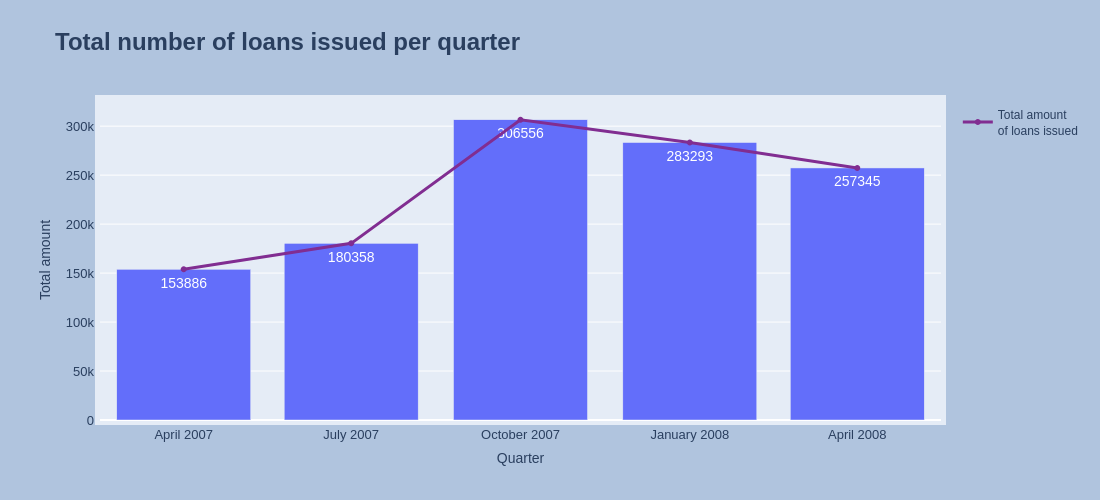

In [334]:
fig = px.bar(
    total_quarters,
    x = 'Quarter start date',
    y = 'Total amount',
    title = 'Total number of loans issued per quarter',
    labels = {'Quarter start date': 'Quarter'},
    text = 'Total amount',
    height = 500
)

fig.update_traces(textfont_size=14, textangle=0, textposition="inside", cliponaxis=False)
fig.update_layout(xaxis = dict(
    tickmode = 'array',
    tickvals = total_quarters['Quarter start date'],
    tickfont_size = 13,
    tickformat = '%B %Y'
), 
    yaxis = dict(
        tickfont_size = 13
    ),
    title_font = dict(size = 24, weight = 'bold'),
    margin=dict(l=100, pad = 5),
    paper_bgcolor="LightSteelBlue"
)
fig.add_trace(go.Scatter(
    x = total_quarters['Quarter start date'], 
    y = total_quarters['Total amount'], 
    name = 'Total amount <br>of loans issued',
    marker_color = '#812d91',
    line_width = 3
))
fig.update_yaxes(automargin='left+top')
fig.show()

<div class = 'alert alert-box alert-success'>
    
>Based on the data and graph, we cannot make assumptions about the growth or decline of loans issued. Unfortunately, we don't have enough data to draw any conclusions in the long term.
    
</div>

## Total number of loan applications per month

In [337]:
total_per_month = pd.read_csv('german_credit.csv', parse_dates=['contract_dt']).sort_values('contract_dt').reset_index(drop = True)
total_per_month.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   age               1000 non-null   int64         
 1   sex               1000 non-null   object        
 2   job               1000 non-null   int64         
 3   housing           1000 non-null   object        
 4   saving_accounts   817 non-null    object        
 5   checking_account  606 non-null    object        
 6   credit_amount     1000 non-null   int64         
 7   duration          1000 non-null   int64         
 8   purpose           1000 non-null   object        
 9   default           1000 non-null   int64         
 10  contract_dt       1000 non-null   datetime64[ns]
 11  client_id         1000 non-null   int64         
dtypes: datetime64[ns](1), int64(6), object(5)
memory usage: 93.9+ KB


In [338]:
# get all months from period
months = pd.period_range(start = total_per_month['contract_dt'].dt.to_period('M').min(), 
                end = total_per_month['contract_dt'].dt.to_period('M').max()).to_frame(name = 'month').reset_index(drop = True)
months

,month
0,2007-05
1,2007-06
2,2007-07
3,2007-08
4,2007-09
5,2007-10
6,2007-11
7,2007-12
8,2008-01
9,2008-02


In [339]:
sum_per_month = (
    total_per_month
    .assign(month = lambda x: x['contract_dt'].dt.to_period('M'))
    .groupby('month')
    [['credit_amount']].sum()
)
sum_per_month

,credit_amount
month,
2007-05,207663
2007-06,239594
2007-07,224333
2007-08,178569
2007-09,186909
2007-10,188534
2007-11,300504
2007-12,273973
2008-01,288080


In [340]:
sum_per_month = months.merge(sum_per_month, on='month', how='left')

In [341]:
sum_per_month.reset_index(drop = True, inplace=True)

In [342]:
sum_per_month = (
    sum_per_month
    .assign(month = lambda x: x['month'].astype('string'))
)

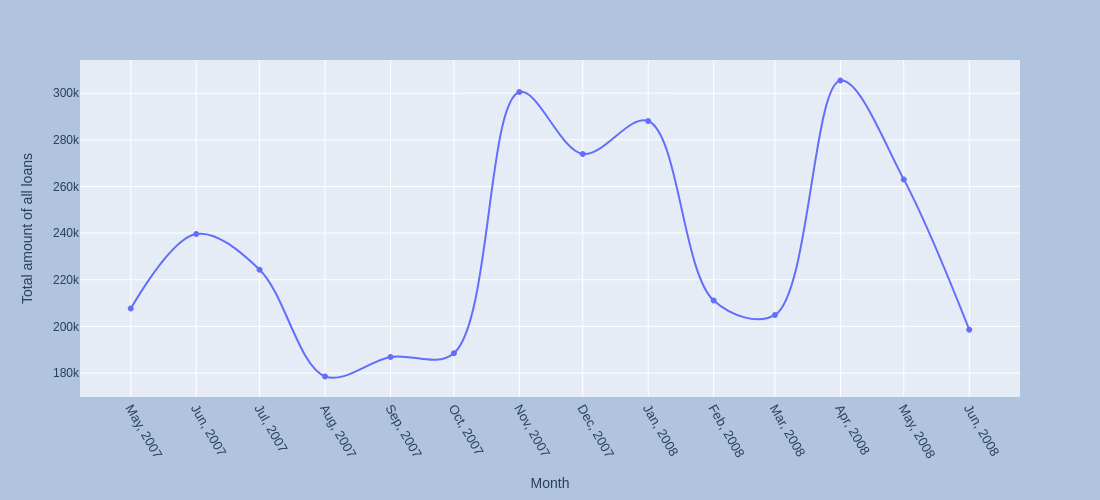

In [343]:
fig = px.line(sum_per_month, 
            x = 'month', 
            y = 'credit_amount', 
            markers = True,
            line_shape = 'spline',
            labels = {'month': 'Month', 'credit_amount': 'Total amount of all loans'},
            height = 500
             )
fig.update_layout(
    xaxis = dict(
        tickmode = 'array',
        tickvals = sum_per_month['month'],
        tickfont_size = 13,
        tickformat = '%b, %Y'
    )
)
fig.update_layout(paper_bgcolor="LightSteelBlue")
fig.update_xaxes(tickangle = 60)
fig.show()

<div class = 'alert alert-box alert-success'>

> Based on available data, it can be assumed that people are more active in taking out loans in the pre-New Year period and in the period before the start of the summer holiday season. But we do not have enough data to confirm these hypotheses.
</div>

## Sum of all loan requests by gender

In [13]:
query = r'''
    SELECT 
        'Sum credit amount' AS Metrics,
        SUM(IF(sex = 'male', credit_amount, 0)) AS male,
        SUM(IF(sex = 'female', credit_amount, 0)) AS female
    FROM german_cr.german_credit
'''
pd.DataFrame(client.query(query).named_results())

,Metrics,male,female
0,Sum credit amount,2379148,892110


In [344]:
query = r'''
    SELECT 
        sex, SUM(credit_amount) AS sum_amount
    FROM german_cr.german_credit
    GROUP BY sex
'''
sex_amount = pd.DataFrame(client.query(query).named_results())
sex_amount

,sex,sum_amount
0,male,2379148
1,female,892110


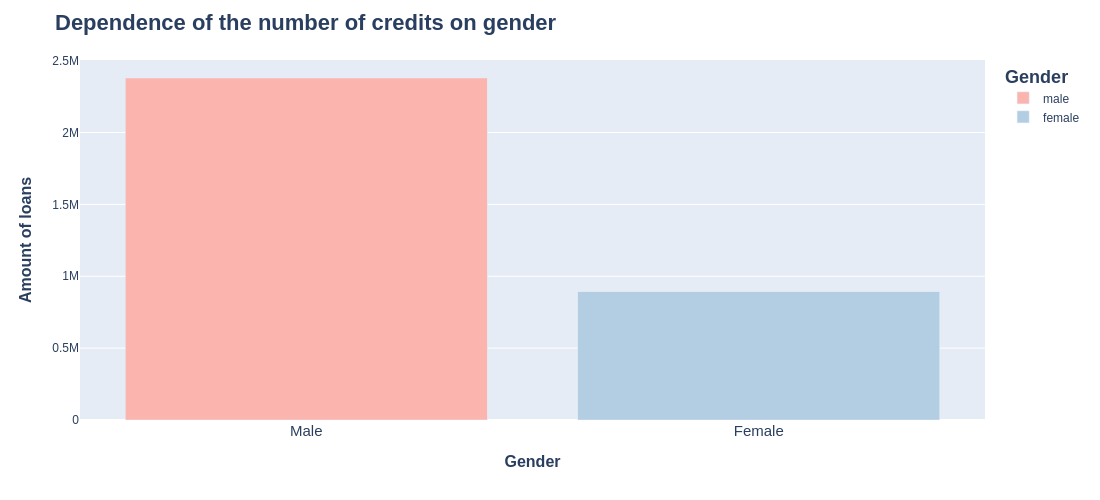

In [354]:
fig = px.bar(
    sex_amount,
    x = 'sex',
    y = 'sum_amount',
    height = 500,
    labels = {'sex': 'Gender', 'sum_amount': 'Amount of loans'},
    color = 'sex',
    color_discrete_sequence=px.colors.qualitative.Pastel1
)
fig.update_layout(
    title = dict(
        text = 'Dependence of the number of credits on gender',
        font = dict(
            size = 22,
            weight = 'bold'
        )
    ),
    xaxis = dict(
        tickmode = 'array',
        tickvals = sex_amount['sex'],
        ticktext = ['Male', 'Female'],
        tickfont_size = 15,
        title_font = dict(
            size = 16,
            weight = 'bold'
        )
    ),
    yaxis = dict(
        title_font = dict(
            size = 16,
            weight = 'bold'
        )
    )
)

fig.update_legends(
    title_font = dict(
        size = 18,
        weight = 'bold'
    )
)

fig.show()

<div class='alert alert-box alert-success'>
    
> Men take out significantly more loans than women. Perhaps this is due to a greater extent to the leading role of men in providing financial support for the family.
</div>

## Sum of all loan requests per month by gender 

In [44]:
# get all months
query = r'''
    DROP VIEW IF EXISTS months
'''
client.command(query)

query = r'''
    CREATE VIEW IF NOT EXISTS months AS 
    WITH get_first AS (
    SELECT MIN(toUnixTimestamp(contract_dt)) AS first_stamp
    FROM german_cr.german_credit
    ), get_last AS (
    SELECT MAX(toUnixTimestamp(contract_dt)) AS last_stamp
    FROM german_cr.german_credit
    ), get_months AS (
    SELECT DISTINCT toStartOfMonth(toDateTime(arrayJoin(range(first_stamp, last_stamp, 60 * 60 * 24 * 28)))) AS months
    FROM get_first, get_last
    )
    SELECT 
        months AS month,
        toMonth(months) AS month_number
    FROM get_months
'''
client.command(query)

query = r'''
    SELECT * FROM months
'''
pd.DataFrame(client.query(query).named_results())

,month,month_number
0,2007-05-01,5
1,2007-06-01,6
2,2007-07-01,7
3,2007-08-01,8
4,2007-09-01,9
5,2007-10-01,10
6,2007-11-01,11
7,2007-12-01,12
8,2008-01-01,1
9,2008-02-01,2


In [356]:
query = r'''
    WITH get_sex AS (
        SELECT 'male' AS sex
        UNION ALL
        SELECT 'female' AS sex    
    )
    SELECT 
        mn.month AS month,
        gc.sex AS sex,
        SUM(gc.credit_amount) AS sum_amount_per_month
    FROM months mn
        CROSS JOIN get_sex gs 
        LEFT JOIN german_cr.german_credit gc ON mn.month = toStartOfMonth(gc.contract_dt) AND gc.sex = gc.sex
    GROUP BY mn.month, gc.sex
    ORDER BY month, sex
'''
loans_per_month = pd.DataFrame(client.query(query).named_results()).rename({'sum_amount_per_month': 'Sum amount per month'}, axis = 1)
loans_per_month.set_index(['month', 'sex'])

Sum amount per month
month      sex                         
2007-05-01 female                 64278
           male                  351048
2007-06-01 female                170340
           male                  308848
2007-07-01 female                113690
           male                  334976
2007-08-01 female                 64910
           male                  292228
2007-09-01 female                127988
           male                  245830
2007-10-01 female                 83052
           male                  294016
2007-11-01 female                157098
           male                  443910
2007-12-01 female                148574
           male                  399372
2008-01-01 female                187066
           male                  389094
2008-02-01 female                169230
           male                  253026
2008-03-01 female                 76122
           male                  333766
2008-04-01 female                170044
           male                  440774
2008-05-01 female                111482
           male                  414604
2008-06-01 female                140346
           male                  256804

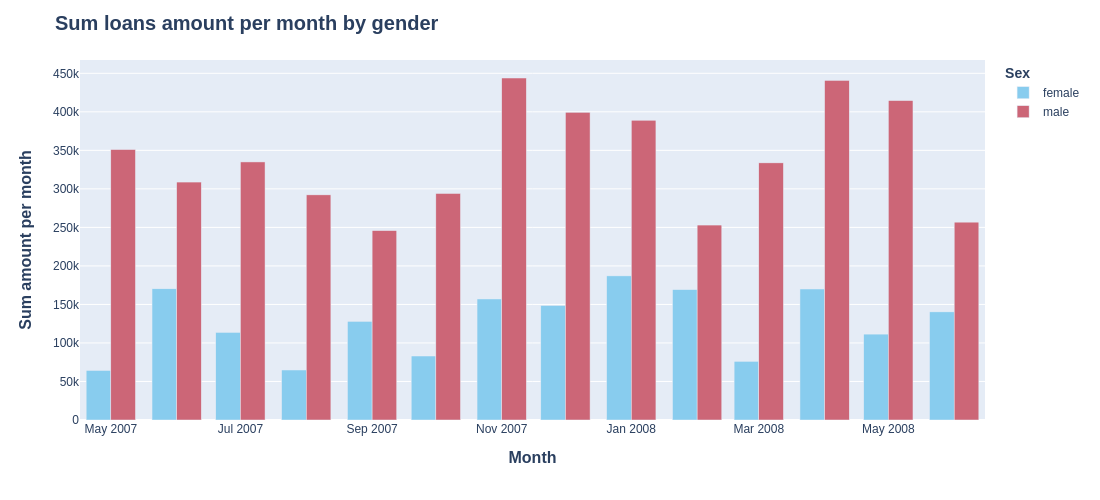

In [358]:
fig = px.bar(
    loans_per_month, 
    x = 'month',
    y = 'Sum amount per month',
    color = 'sex',
    barmode = 'group',
    labels = {'month': 'Month'},
    color_discrete_sequence=px.colors.qualitative.Safe,
    height = 500
)
fig.update_legends(
    title = dict(text = 'Sex',
                 font_size = 14,
                 font_weight = 'bold'
                )
)
fig.update_layout(
    title = dict(
        text = 'Sum loans amount per month by gender',
        font = dict(
            size = 20,
            weight = 'bold'
        )
    ),
    xaxis = dict(
        title_font = dict(
            size = 16,
            weight = 'bold'
        )
    ),
    yaxis = dict(
        title_font = dict(
            size = 16,
            weight = 'bold'
        )
    )
)
fig.show()

## Dependence of the ratio of the amount of loans by category

In [14]:
query = r'''
    SELECT
        toStartOfMonth(gc.contract_dt) AS Month,
        gc.purpose AS Purpose,
        SUM(gc.credit_amount) AS sum_amount
    FROM german_cr.german_credit gc
    GROUP BY Month, Purpose
    ORDER BY Month
'''
amount_purpose = pd.DataFrame(client.query(query).named_results())
amount_purpose.head()

,Month,Purpose,sum_amount
0,2007-05-01,furniture/equipment,25843
1,2007-05-01,vacation/others,17021
2,2007-05-01,domestic appliances,3990
3,2007-05-01,business,6382
4,2007-05-01,repairs,4356


In [359]:
# order the xaxes by value of sum_amount (in first month avaliable)
cat_order = (
    amount_purpose
        .query('Month.astype("string") == "2007-05-01" ')
        .sort_values(['sum_amount'], ascending = False)['Purpose'].to_list()
)
cat_order

['car',
 'radio/TV',
 'furniture/equipment',
 'vacation/others',
 'education',
 'business',
 'repairs',
 'domestic appliances']

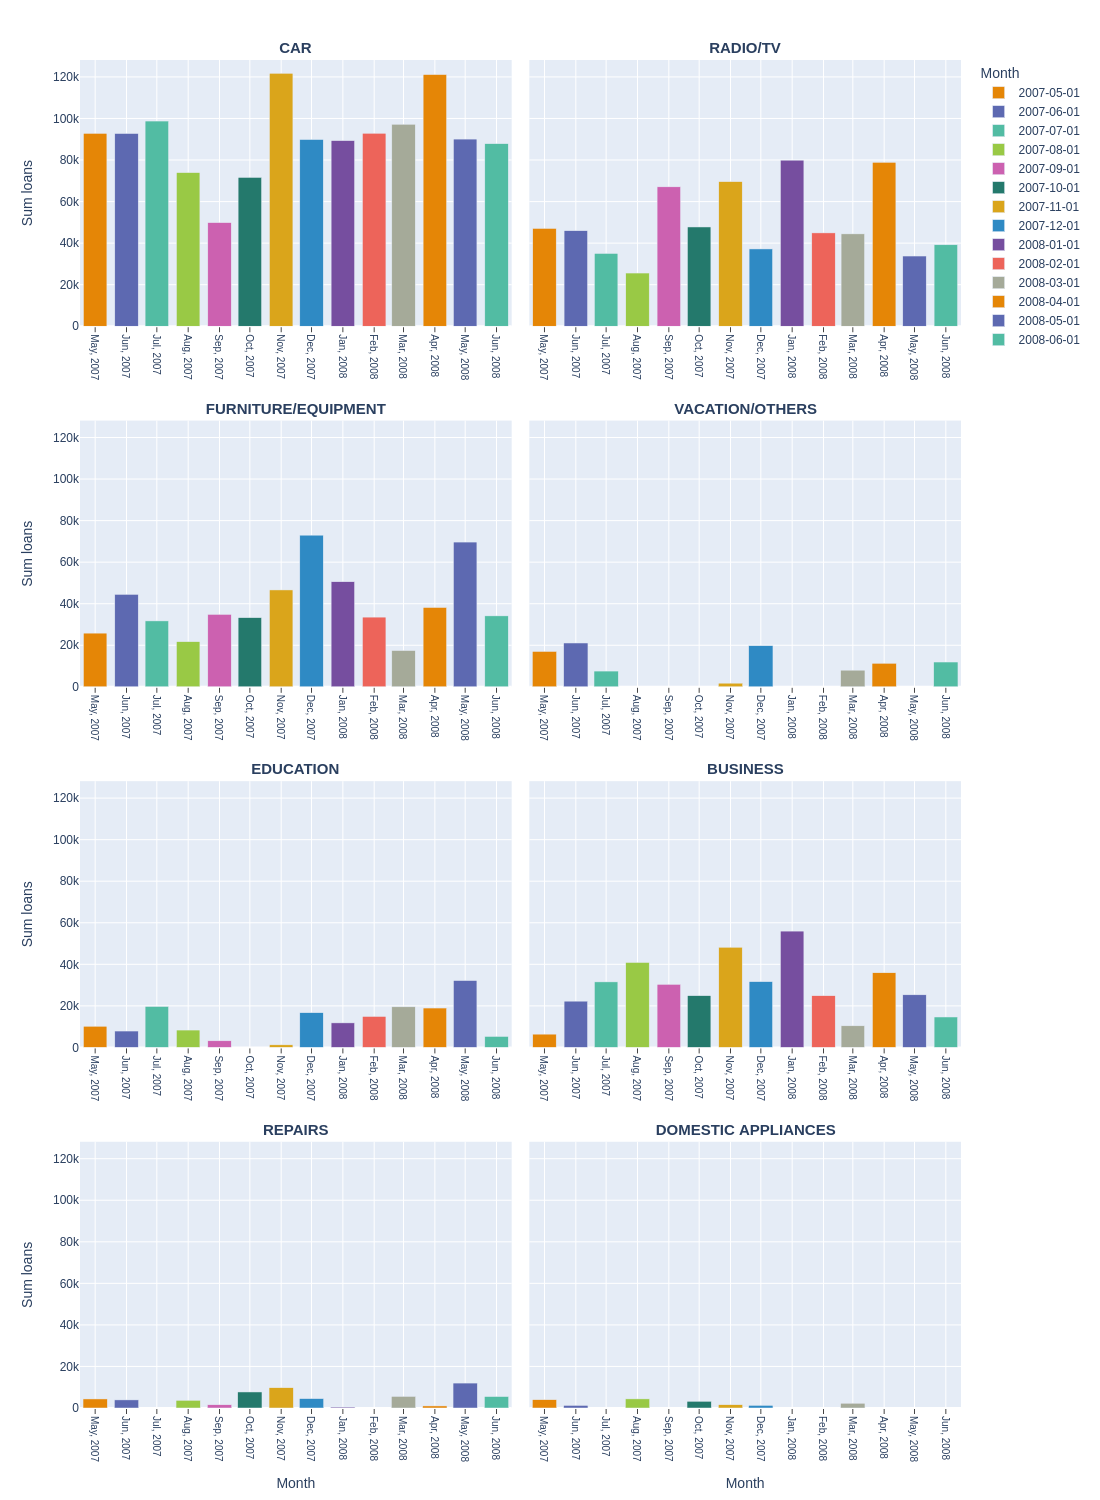

In [360]:
fig = px.bar(
    amount_purpose.sort_values('Month'),
    x = 'Month',
    y = 'sum_amount',
    facet_col = 'Purpose',
    facet_col_wrap = 2,
    labels = {'sum_amount': 'Sum loans'},
    color = 'Month',
    category_orders = {'Purpose': cat_order},
    color_discrete_sequence=px.colors.qualitative.Vivid,
    height = 1500
)
fig.for_each_annotation(lambda x: x.update(text = x.text.split("=")[-1], font = dict(size = 15, weight = 'bold', textcase = 'upper')))
fig.update_xaxes(tickangle = 90, showgrid=True, ticks="outside")
# fig.add_annotation(row=5, col=1, x='car', y=80000, text="car", arrowhead=1)
fig.for_each_xaxis(lambda x: x.update(tickmode = 'array',
                            tickvals = amount_purpose['Month'],
                            tickfont_size = 10,
                            tickformat = '%b, %Y'))
fig.for_each_xaxis(lambda xaxis: xaxis.update(showticklabels=True))
fig.show()

<div class = 'alert alert-box alert-success'>

> Unfortunately, the graphs cannot make any assumptions about the interdependence of variables
</div>

## Correlation map of numeric variables

In [361]:
numeric_vars = pd.read_csv('german_credit.csv').select_dtypes('number')[['age', 'credit_amount', 'duration']]
numeric_vars.head()

,age,credit_amount,duration
0,33,3074,9
1,43,1344,12
2,52,936,9
3,35,1393,11
4,28,776,12


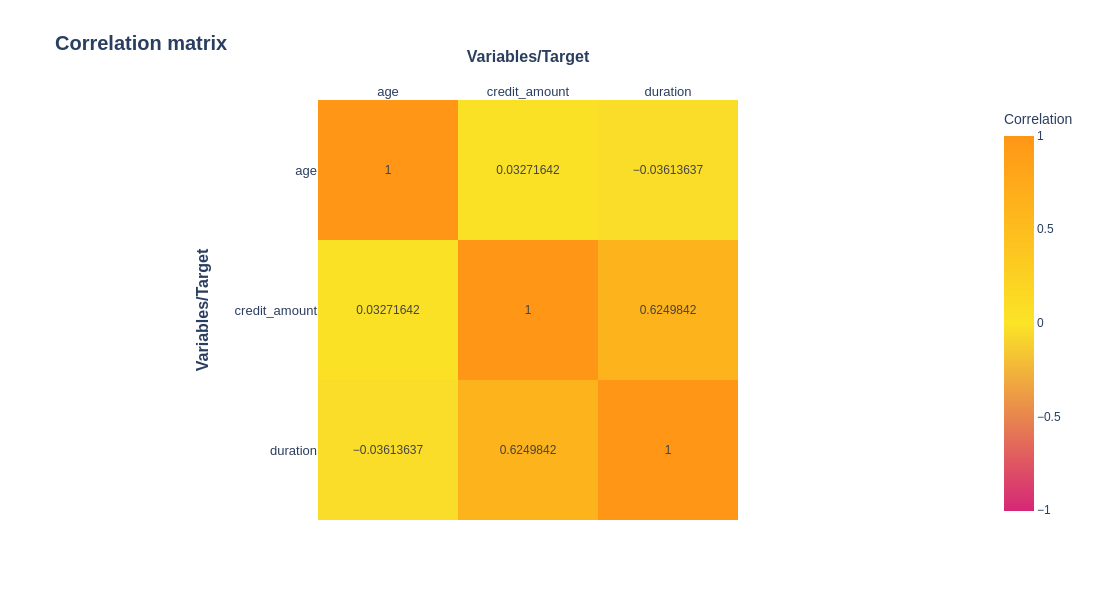

In [366]:
fig = px.imshow(
    numeric_vars.corr(),
    text_auto = True,
    color_continuous_scale = [(0, '#D62677'), (0.5, '#FBE426'), (1, '#FF9616')],
    range_color = [-1, 1],
    title = 'Correlation matrix',
    labels=dict(x="Variables/Target", 
                y="Variables/Target", 
                color="Correlation"),
    height = 600
)
fig.update_layout(titlefont = dict(size = 20, weight = 'bold'))
fig.update_xaxes(side="top", titlefont = dict(size = 16, weight = 'bold'), tickfont_size = 13, tickangle = 0)
fig.update_yaxes(titlefont = dict(size = 16, weight = 'bold'), tickfont_size = 13)
fig.update_annotations(font_size = 15)

fig.show()

<div class = 'alert alert-box alert-success'>

> As we can see in the heatmap, there is a correlation between the loan size and the duration of repayment (which is quite logical). 
</div>

## The amount of loans requested depending on the age category 

In [367]:
df = pd.read_csv('german_credit.csv')
df.head()

,age,sex,job,housing,saving_accounts,checking_account,credit_amount,duration,purpose,default,contract_dt,client_id
0,33,male,2,own,NaN,NaN,3074,9,radio/TV,0,2008-06-29 18:52:00,210
1,43,male,1,own,little,little,1344,12,car,0,2007-05-20 18:30:19,929
2,52,male,2,own,quite rich,NaN,936,9,education,0,2008-04-27 08:23:07,200
3,35,female,3,own,little,NaN,1393,11,car,0,2007-05-06 10:58:22,45
4,28,male,2,own,little,NaN,776,12,radio/TV,0,2007-07-21 13:22:14,358


## Let's look at the distribution of the age variable

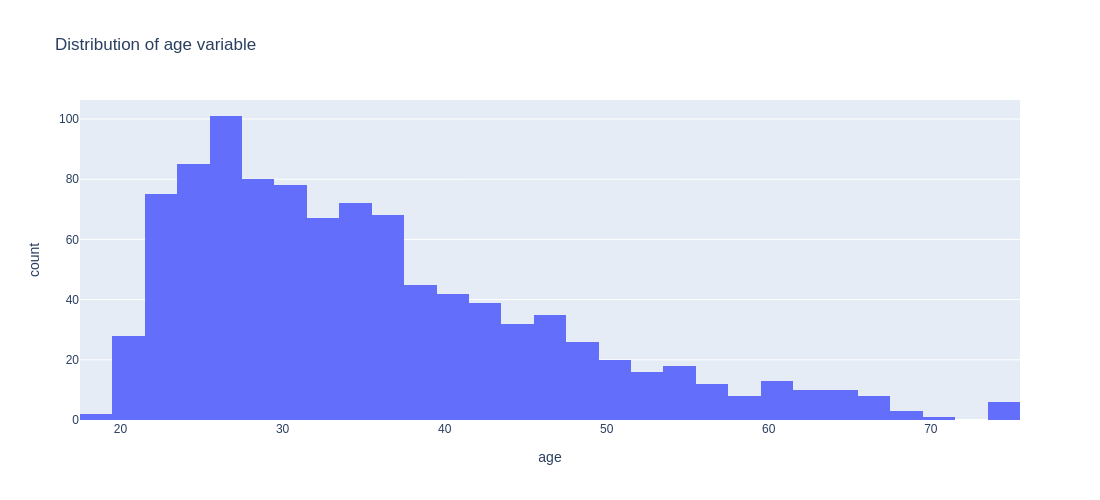

In [369]:
fig = px.histogram(
    df,
    x = 'age',
    title = 'Distribution of age variable',
    height = 500
)
fig.show()

In [40]:
age_distr = (
    df
    .assign(Age_category = lambda x: pd.cut(x['age'], bins = [0, 28, 38, 100], labels = ['young', 'middle age', 'elderly']))
)[['Age_category']].value_counts(sort=False).to_frame()
age_distr

,count
Age_category,
young,334
middle age,346
elderly,320


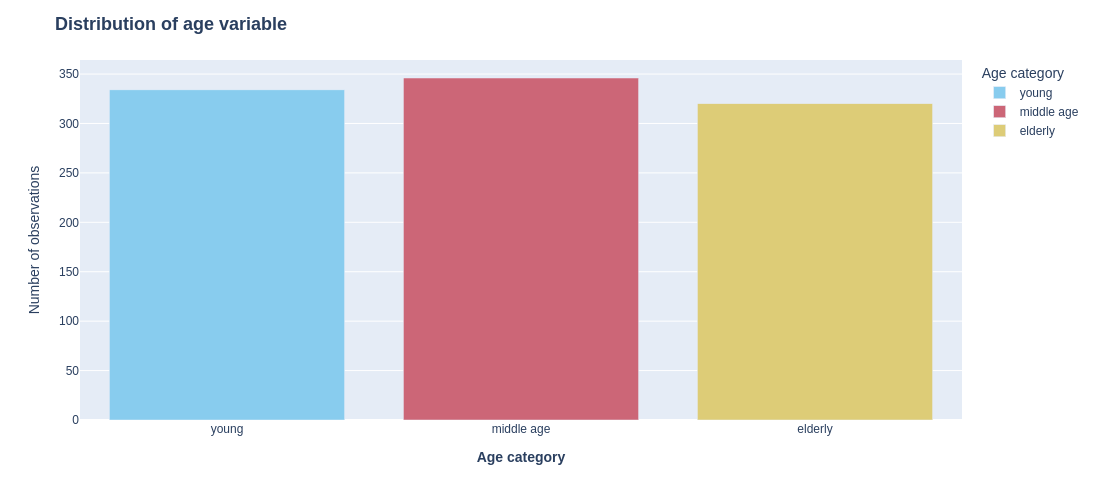

In [370]:
fig = px.bar(
    age_distr.reset_index(),
    x = 'Age_category',
    y = 'count',
    color = 'Age_category',
    color_discrete_sequence = px.colors.qualitative.Safe, 
    labels = dict(
        Age_category = 'Age category',
        count = 'Number of observations'
    ),
    height = 500
)
fig.update_layout(
    title = dict(
        text = 'Distribution of age variable',
        font = dict(
            size = 18,
            weight = 'bold'
        )
    ),
    xaxis = dict(
        title = dict(
            text = 'Age category',
            font_weight = 'bold'
        )
    ),
    yaxis = dict(
        title = dict(
            text = 'Number of observations'
        )
    )
)
fig.show()

#### The same operation in SQL

In [70]:
query = r'''
    WITH get_category AS (
    SELECT 
        age, 
        NTILE(3) OVER w AS Age_category
    FROM german_cr.german_credit
    WINDOW w AS (
        ORDER BY age
    ))
    SELECT 
        CASE 
            WHEN Age_category = 1 THEN 'young'
            WHEN Age_category = 2 THEN 'middle age'
            ELSE 'elderly'
        END AS Age_category,
        COUNT(*) AS `Number of observations`
    FROM get_category
    GROUP BY Age_category
'''
pd.DataFrame(client.query(query).named_results()).set_index('Age_category')

,Number of observations
Age_category,
young,334
elderly,333
middle age,333


### Split into purposes

In [371]:
query = r'''
    WITH get_category AS (
    SELECT 
        purpose,
        NTILE(3) OVER w AS age_category,
        credit_amount
    FROM german_cr.german_credit
    WINDOW w AS (
        ORDER BY age
    ))
    SELECT
        purpose,
        CASE 
            WHEN age_category = 1 THEN 'young'
            WHEN age_category = 2 THEN 'middle age'
            ELSE 'elderly'
        END AS age_category,
        SUM(credit_amount) AS sum_amount
    FROM get_category
    GROUP BY purpose, age_category 
    ORDER BY purpose, age_category
'''
sum_by_age = pd.DataFrame(client.query(query).named_results())
sum_by_age

,purpose,age_category,sum_amount
0,business,elderly,121640
1,business,middle age,146770
2,business,young,134920
3,car,elderly,520424
4,car,middle age,425974
5,car,young,323483
6,domestic appliances,elderly,5606
7,domestic appliances,middle age,6477
8,domestic appliances,young,5893
9,education,elderly,67830


### Wide format

In [76]:
query = r'''
    WITH get_category AS (
    SELECT 
        purpose,
        NTILE(3) OVER w AS Age_category,
        credit_amount
    FROM german_cr.german_credit
    WINDOW w AS (
        ORDER BY age
    ))
    SELECT
        purpose,
        SUM(CASE WHEN Age_category = 1 THEN credit_amount ELSE 0 END) AS young,
        SUM(CASE WHEN Age_category = 2 THEN credit_amount ELSE 0 END) AS middle_age,
        SUM(CASE WHEN Age_category = 3 THEN credit_amount ELSE 0 END) AS elderly
    FROM get_category
    GROUP BY purpose
    ORDER BY purpose
'''
pd.DataFrame(client.query(query).named_results()).set_index('purpose')

,young,middle_age,elderly
purpose,,,
business,134920,146770,121640
car,323483,425974,520424
domestic appliances,5893,6477,5606
education,40464,61579,67830
furniture/equipment,218664,175536,160925
radio/TV,274490,254058,167995
repairs,11919,18387,29712
vacation/others,6314,39963,52235


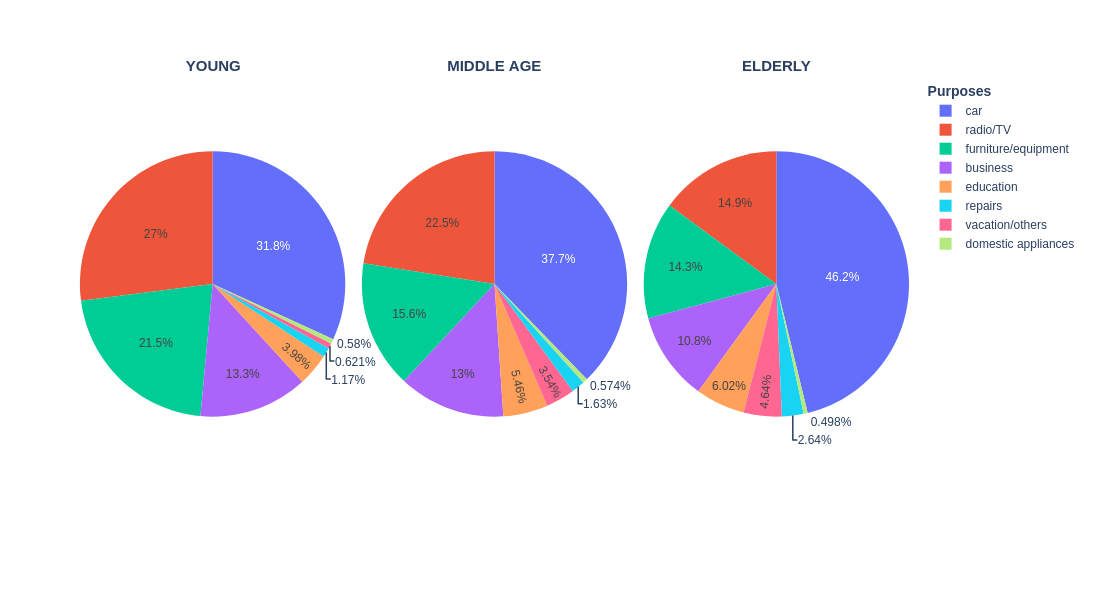

In [373]:
fig = px.pie(
    sum_by_age,
    values = 'sum_amount',
    facet_col = 'age_category',
    names = 'purpose',
    labels = {
        'age_category': 'Age category',
        'purpose': 'Purpose of loan',
        'sum_amount': 'Sum amount of loans by groups'
    },
    category_orders = {
        'age_category': ['young', 'middle age', 'elderly']
    },
    height = 600
)
fig.for_each_annotation(
    lambda x: x.update(
        text = x.text.split("=")[-1], 
        font = dict(size = 15, 
                    weight = 'bold', 
                    textcase = 'upper')
    )
)
fig.update_legends(
    title = dict(
        text = 'Purposes',
        font_weight = 'bold'
    )
)

fig.show()

<div class = 'alert alert-box alert-success'>

> Based on the graph above, we can conclude that as people age, they take out more loans for a car and less for a TV/radio
</div>

## The amount of loans requested depending on the age category, purpose and sex

In [374]:
df = pd.read_csv('german_credit.csv')
df.head()

,age,sex,job,housing,saving_accounts,checking_account,credit_amount,duration,purpose,default,contract_dt,client_id
0,33,male,2,own,NaN,NaN,3074,9,radio/TV,0,2008-06-29 18:52:00,210
1,43,male,1,own,little,little,1344,12,car,0,2007-05-20 18:30:19,929
2,52,male,2,own,quite rich,NaN,936,9,education,0,2008-04-27 08:23:07,200
3,35,female,3,own,little,NaN,1393,11,car,0,2007-05-06 10:58:22,45
4,28,male,2,own,little,NaN,776,12,radio/TV,0,2007-07-21 13:22:14,358


In [106]:
sum_by_sex_age_purpose = (
    df
    .assign(age_cat = lambda x: pd.cut(x['age'], bins = [0, 28, 38, 100], labels = ['young', 'middle age', 'elderly']))
    .groupby(['sex', 'purpose', 'age_cat'], observed=False)['credit_amount'].sum().to_frame()
).reset_index()
# pd.pivot_table(sum_by_sex_age_purpose, columns = ['sex', 'age_cat'], index = ['purpose'])


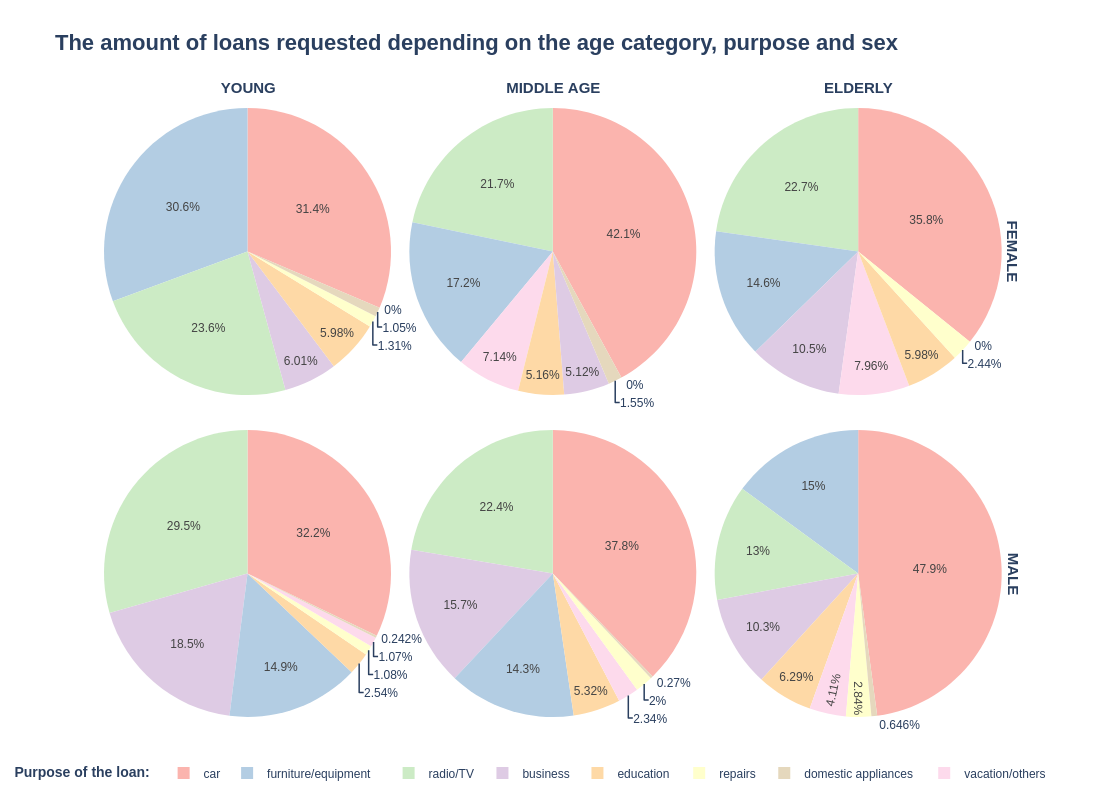

In [149]:
fig = px.pie(
    sum_by_sex_age_purpose,
    values = 'credit_amount',
    facet_col = 'age_cat',
    facet_row = 'sex',
    names = 'purpose',
    labels = {
        'sex': 'Sex',
        'age_cat': 'Age category',
        'purpose': 'Purpose of the loan',
        'credit_amount': 'Sum of amounts by groups'
    },
    color_discrete_sequence = px.colors.qualitative.Pastel1, 
    height = 800,
)

fig.update_legends(
    title = dict(
        text = 'Purpose of the loan:',
        font = dict(
            size = 14,
            weight = 'bold'
        )
    ),
    yanchor = "bottom",
    y = -0.1,
    xanchor = "left",
    x = -0.1, 
    orientation = 'h'
)

fig.update_layout(
    title = dict(
        text = 'The amount of loans requested depending on the age category, purpose and sex',
        font = dict(
            size = 22,
            weight = 'bold'
        )
    ),
    margin = dict(
        # l = 20,
        # r = 20, 
        t = 100, 
        b = 50
    ),
    autosize = True
)

fig.for_each_annotation(
    lambda x: x.update(
        text = x.text.split("=")[-1], 
        font = dict(size = 15, 
                    weight = 'bold', 
                    textcase = 'upper')
    )
)
fig.show()

<div class = 'alert alert-box alert-success'>

>Judging by the graphs, we can conclude that young girls take much more credits on furneture than middle-aged and older girls. Despite the fact that this trend is not observed among men. It is also interesting that it is middle-aged girls who take out car loans from women more often, while it is mainly the elderly who take out car loans from men.    
</div>

## Prediction of loan amount by gender, age, purpose

In [163]:
# Import libraries
import catboost as cb
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, root_mean_squared_error

```
Since we are dealing with the prediction of a continuum variable, we use regression analysis. The model has proven itself in various tasks, we choose catBoost

```

In [155]:
# Selecting features and target variables
X = df[['sex', 'age', 'purpose']]
y = df['credit_amount']

In [152]:
X.head()

,sex,age,purpose
0,male,33,radio/TV
1,male,43,car
2,male,52,education
3,female,35,car
4,male,28,radio/TV


In [156]:
# One-hot encoding
X_dum = pd.get_dummies(X, columns=['sex', 'purpose'])
X_dum.head()

,age,sex_female,sex_male,purpose_business,purpose_car,purpose_domestic appliances,purpose_education,purpose_furniture/equipment,purpose_radio/TV,purpose_repairs,purpose_vacation/others
0,33,False,True,False,False,False,False,False,True,False,False
1,43,False,True,False,True,False,False,False,False,False,False
2,52,False,True,False,False,False,True,False,False,False,False
3,35,True,False,False,True,False,False,False,False,False,False
4,28,False,True,False,False,False,False,False,True,False,False


In [183]:
# Split to train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=1234)

In [184]:
# Fitting the model
model = CatBoostRegressor(iterations=500, learning_rate=0.1, depth=6, verbose=0)
model.fit(X_train, y_train, cat_features=['sex', 'purpose'])

In [185]:
# Making forecasts and evaluating the model
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

In [186]:
# Calculate indicators on the training set
print(f'MSE_train = {mean_squared_error(y_pred_train, y_train)}')
print(f'RMSE_train = {root_mean_squared_error(y_pred_train, y_train)}')

MSE_train = 5656386.385753054
RMSE_train = 2378.315871736354


In [187]:
# Calculate indicators on the test set
print(f'MSE_test = {mean_squared_error(y_pred_test, y_test)}')
print(f'RMSE_test = {root_mean_squared_error(y_pred_test, y_test)}')

MSE_test = 10915178.60265728
RMSE_test = 3303.8127372260797


### Now we will try to select more successful model hyperparameters

In [171]:
# import library
from sklearn.model_selection import GridSearchCV

In [188]:
X_train, X_test, y_train, y_test = train_test_split(X_dum, y, test_size=0.2, shuffle=True, random_state=1234)

model = CatBoostRegressor(loss_function='RMSE', verbose=0)
param_grid = {
    'iterations': [100, 200, 500], 
    'learning_rate': [0.1, 0.05, 0.01], 
    'depth': [ 4, 6, 8]
}
search = GridSearchCV(model, param_grid)
search.fit(X_train, y_train)

GridSearchCV(estimator=<catboost.core.CatBoostRegressor object at 0x7c4fccc4c6b0>,
             param_grid={'depth': [4, 6, 8], 'iterations': [100, 200, 500],
                         'learning_rate': [0.1, 0.05, 0.01]})

In [189]:
search.best_params_

{'depth': 4, 'iterations': 100, 'learning_rate': 0.05}

In [190]:
# Making forecasts and evaluating the model with best hyperparams
y_pred_train_best_estimator = search.best_estimator_.predict(X_train)
y_pred_test_best_estimator = search.best_estimator_.predict(X_test)

In [192]:
# Calculate indicators on the training set
print(f'MSE_train = {mean_squared_error(y_pred_train_best_estimator, y_train)}')
print(f'RMSE_train = {root_mean_squared_error(y_pred_train_best_estimator, y_train)}')

MSE_train = 6320752.1381590655
RMSE_train = 2514.110605792646


In [193]:
# Calculate indicators on the test set
print(f'MSE_test = {mean_squared_error(y_pred_test_best_estimator, y_test)}')
print(f'RMSE_test = {root_mean_squared_error(y_pred_test_best_estimator, y_test)}')

MSE_test = 9809172.063082935
RMSE_test = 3131.9597799274075


<div class='alert alert-box alert-success'>

>On test data, the model with the selected hyperparameters performs slightly better.
</div>

## Percentage of loans issued from the total <br>number for men and women for different loan purposes

In [197]:
df = pd.read_csv('german_credit.csv')
df.head()

,age,sex,job,housing,saving_accounts,checking_account,credit_amount,duration,purpose,default,contract_dt,client_id
0,33,male,2,own,NaN,NaN,3074,9,radio/TV,0,2008-06-29 18:52:00,210
1,43,male,1,own,little,little,1344,12,car,0,2007-05-20 18:30:19,929
2,52,male,2,own,quite rich,NaN,936,9,education,0,2008-04-27 08:23:07,200
3,35,female,3,own,little,NaN,1393,11,car,0,2007-05-06 10:58:22,45
4,28,male,2,own,little,NaN,776,12,radio/TV,0,2007-07-21 13:22:14,358


#### Count of target variable (approved or rejected)

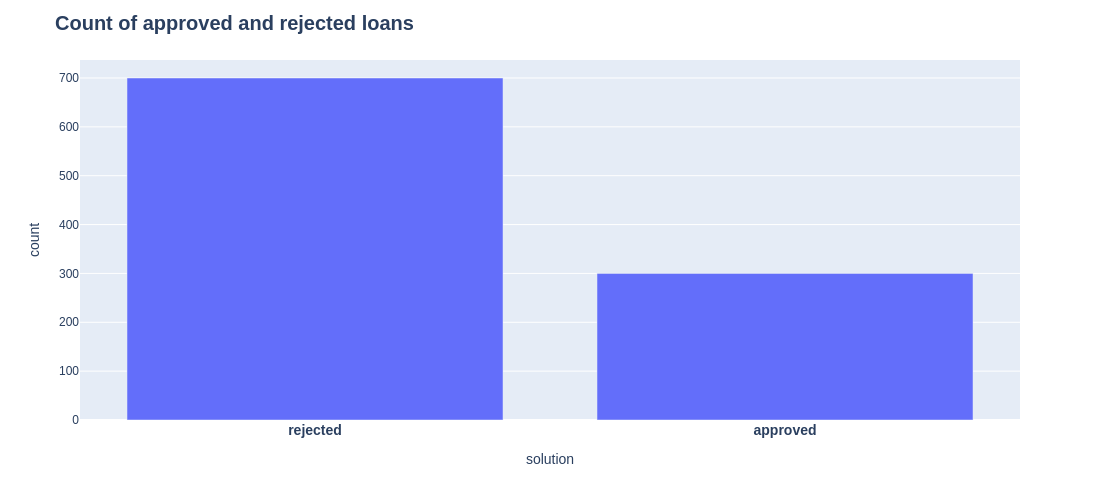

In [375]:
fig = px.bar(
    df['default'].value_counts().to_frame().reset_index().rename({'default': 'solution'}, axis = 1),
    x = 'solution',
    y = 'count',
    height = 500
)
fig.update_layout(
    xaxis = dict(
        tickmode = 'array',
        tickvals = [0, 1],
        ticktext = ['rejected', 'approved'],
        tickfont_weight = 'bold',
        tickfont_size = 14
    ),
    title = dict(
        text = 'Count of approved and rejected loans',
        font = dict(
            size = 20,
            weight = 'bold'
        )
    )
)
fig.show()

In [262]:
query = r'''
    SELECT 
        sex AS Gender,
        purpose AS Purpose,
        ROUND(SUM(default) * 100.0/COUNT(*), 2) as `Percent of approved loans, %` 
    FROM german_cr.german_credit
    GROUP BY sex, purpose
    ORDER BY sex, purpose
'''
pd.DataFrame(client.query(query).named_results())

,Gender,Purpose,"Percent of approved loans, %"
0,female,business,36.84
1,female,car,42.55
2,female,domestic appliances,33.33
3,female,education,37.50
4,female,furniture/equipment,37.84
5,female,radio/TV,22.35
6,female,repairs,40.00
7,female,vacation/others,66.67
8,male,business,34.62
9,male,car,27.16


In [326]:
query = r'''
    SELECT 
        sex AS Gender,
        purpose AS Purpose,
        CASE WHEN default = 1 THEN 'approved' ELSE 'rejected' END AS `Is approved`,
        COUNT(*) AS `Number of observations`
    FROM german_cr.german_credit
    GROUP BY sex, purpose, default
    ORDER BY sex, purpose
'''
loan_approved = pd.DataFrame(client.query(query).named_results())
loan_approved.head()

,Gender,Purpose,Is approved,Number of observations
0,female,business,approved,7
1,female,business,rejected,12
2,female,car,approved,40
3,female,car,rejected,54
4,female,domestic appliances,rejected,4


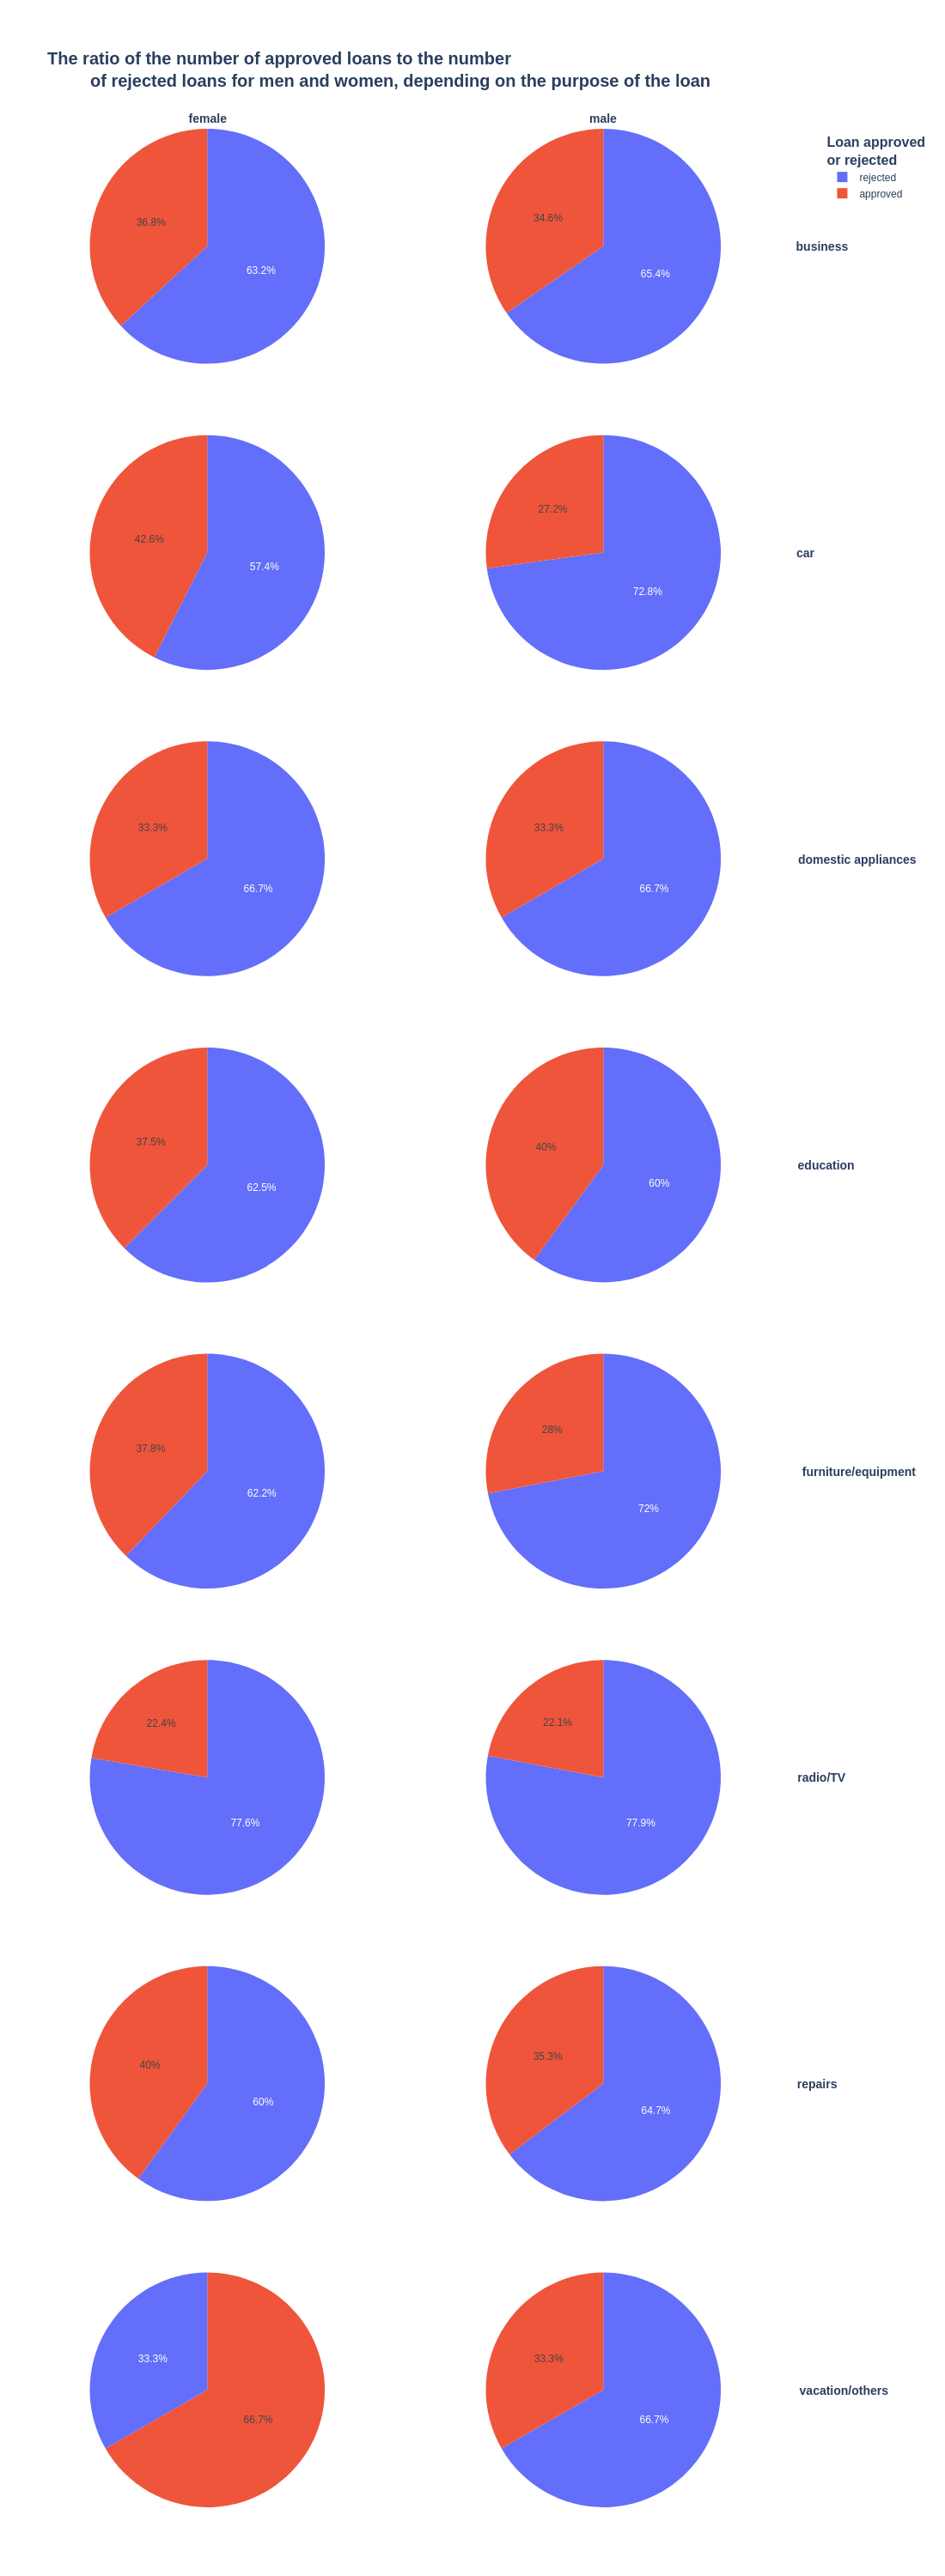

In [383]:
fig = px.pie(
    loan_approved,
    values = 'Number of observations',
    names = 'Is approved',
    facet_row = 'Purpose',
    facet_col = 'Gender'
)

fig.update_legends(
    title = dict(
        text = 'Loan approved <br>or rejected',
        font = dict(
            size = 16,
            weight = 'bold'
        )
    )
)

fig.update_layout(
    title = dict(
        text = r'''The ratio of the number of approved loans to the number<br>
        of rejected loans for men and women, depending on the purpose of the loan<br>''',
        font_size = 20,
        font_weight = 'bold'
    ),
    # autosize = False,
    margin=dict(pad = 100, t = 150, l = 20, r = 20),
    height = 3000,
)

fig.for_each_annotation(
    lambda x: x.update(
        text = x.text.split('=')[-1],
        font = dict(
            size = 14,
            weight = 'bold'
        ),
        textangle = 0
    )
)
fig.show()

<div class = 'alert alert-box alert-success'>

>As we can see from the graphs, in categories such as car and furniture/equipment, girls are approved for loans more often than men. It can also be said that in areas such as education and business, loans in general are approved more often than for the purchase of televisions and other equipment
</div>

## Clastering

In [21]:
import pandas as pd
import plotly.express as px
from sklearn.cluster import KMeans

In [3]:
gc = pd.read_csv('german_credit.csv', 
                 dtype={
                    'sex': 'category',
                    'job': 'category', 
                    'housing': 'category',
                    'purpose': 'category',
                    'default': 'category', 
                    'client_id': 'category',   
                    },
                 parse_dates=['contract_dt'],
                 ).sort_values('contract_dt').reset_index(drop=True)

In [5]:
gc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   age               1000 non-null   int64         
 1   sex               1000 non-null   category      
 2   job               1000 non-null   category      
 3   housing           1000 non-null   category      
 4   saving_accounts   817 non-null    object        
 5   checking_account  606 non-null    object        
 6   credit_amount     1000 non-null   int64         
 7   duration          1000 non-null   int64         
 8   purpose           1000 non-null   category      
 9   default           1000 non-null   category      
 10  contract_dt       1000 non-null   datetime64[ns]
 11  client_id         1000 non-null   category      
dtypes: category(6), datetime64[ns](1), int64(3), object(2)
memory usage: 94.8+ KB


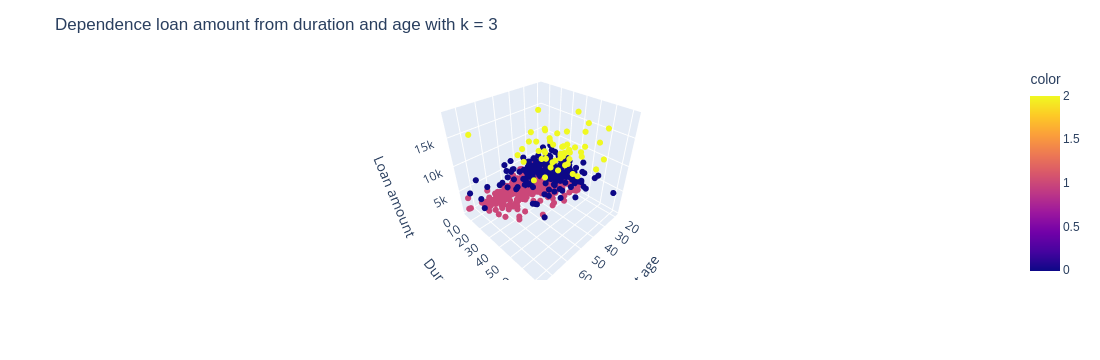

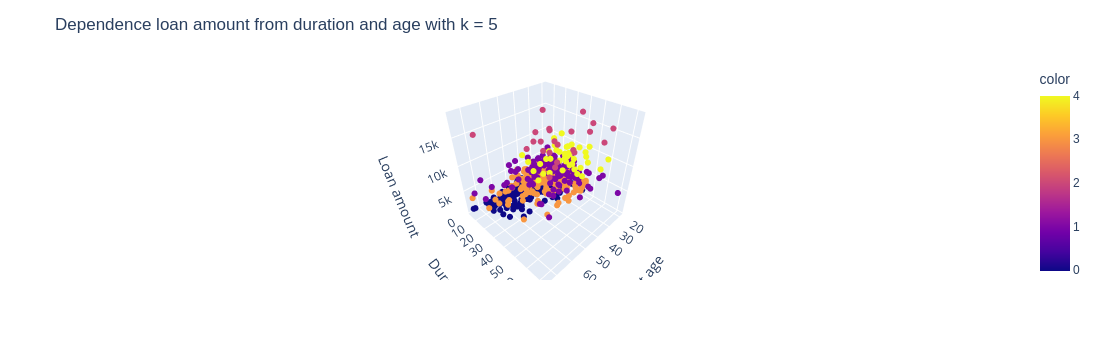

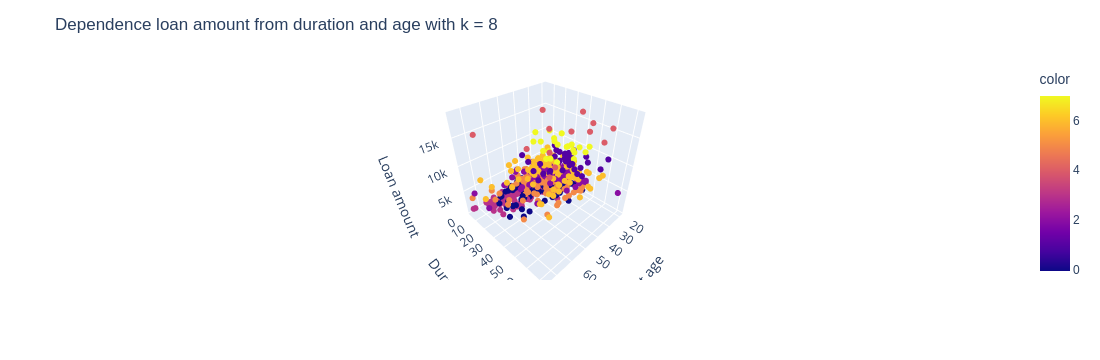

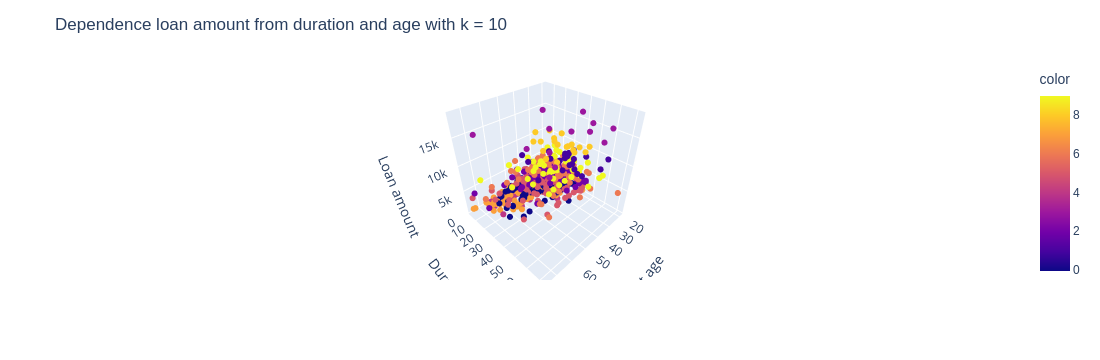

In [46]:
gc_cluster = gc[['age', 'duration', 'credit_amount']]
for k in [3, 5, 8, 10]:
    km = KMeans(k)
    km.fit(gc_cluster)
    predicted_clusters = km.predict(gc_cluster)
    fig = px.scatter_3d(
    gc_clustered,
    x = 'age',
    y = 'duration',
    z = 'credit_amount',
    color = predicted_clusters,
    labels= {
        'age': 'Client age',
        'duration': 'Duration',
        'credit_amount': 'Loan amount'
    }
    )
    fig.update_layout(
        title = dict(
            text = f'Dependence loan amount from duration and age with k = {k}'
        )
    )
    fig.update_traces(
        marker_size = 2
    )
    fig.show()